In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import UnivariateSpline
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
%matplotlib inline

# Import EGC csv data

In [14]:
from google.colab import drive
drive.mount('/content/drive')
EGC_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ECG_data/0618_2020_case1_2_6_by ml_A.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Checking the data 

In [3]:
print(EGC_data.shape)
EGC_data.head()

(2140, 65)


,phistnum,datetime,data skip,contraction,Intensity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
0,3923710,2020/5/28 18:53,False,True,70,-143,-144,-143,-139,137,-138,-138,139,-139,-142,-143,140,142,142,143,141,141,142,143,144,144,146,143,143,141,138,138,135,134,132,131,134,136,139,141,143,141,140,140,142,143,143,143,141,138,132,132,133,132,135,134,135,135,135,134,136,132,133,131,-130
1,3923710,2020/5/28 18:53,False,True,70,35,30,30,27,29,30,34,37,38,39,41,44,45,48,49,52,54,54,55,55,55,57,59,60,61,64,65,68,69,69,69,67,66,63,63,64,64,62,61,60,59,58,56,55,52,51,49,46,46,44,44,43,42,41,40,39,40,39,39,37
2,3923710,2020/5/28 18:54,False,True,70,36,36,36,37,35,34,32,31,31,30,30,30,29,28,28,28,28,28,28,28,26,26,25,25,25,25,25,25,24,25,24,24,23,24,23,24,24,24,24,24,23,24,24,26,25,24,23,23,23,22,21,21,21,22,21,22,22,21,21,21
3,3923710,2020/5/28 18:54,False,False,22,-132,132,131,131,133,134,134,132,131,131,126,129,129,128,126,129,132,131,130,132,-133,-130,-135,-132,-132,132,134,134,136,139,140,141,143,144,144,145,144,143,142,143,143,141,140,141,-140,-137,-139,140,139,141,140,138,133,134,131,133,136,138,139,140
4,3923710,2020/5/28 18:55,False,False,22,28,26,28,29,30,28,27,24,24,25,25,25,25,25,24,25,23,22,22,26,26,26,26,24,23,26,32,30,35,30,25,19,18,21,23,24,25,26,27,28,29,31,32,33,34,36,39,41,45,47,49,51,54,56,58,61,62,64,68,69


In [4]:
IDs = list(set(EGC_data.iloc[:,0].values))

# LSTM model

## Preparing the data

In [15]:
EGC_data.drop(columns = ['Intensity'], inplace = True)

In [16]:
data_1 = EGC_data[EGC_data['phistnum'] == IDs[0]]
data_2 = EGC_data[EGC_data['phistnum'] == IDs[1]]
data_3 = EGC_data[EGC_data['phistnum'] == IDs[2]]
data_t = EGC_data[np.logical_or((EGC_data['phistnum'] == IDs[1]),(EGC_data['phistnum'] == IDs[2]))]


ECG_data_clean = EGC_data[EGC_data['data skip'] == False]

In [7]:
print(data_1.shape,data_2.shape,data_3.shape,data_t.shape)

(267, 64) (1020, 64) (853, 64) (1873, 64)


In [17]:
train_data_1 = data_2.iloc[:,3:].values.astype(int)
train_y_1 = data_2.iloc[:,3].values.astype(int)

train_data_2 = data_3.iloc[:,3:].values.astype(int)
train_y_2 = data_3.iloc[:,3].values.astype(int)

train_data_t = data_t.iloc[:,3:].values.astype(int)
train_y = data_t.iloc[:,3].values.astype(int)

test_data = data_1.iloc[:,3:].values.astype(int)
test_y = data_1.iloc[:,3].values.astype(int)

whole_data = ECG_data_clean.iloc[:,3:].values.astype(int)

In [ ]:
print(train_data_1.shape,test_data.shape,train_data_t.shape)

(267, 183) (267, 61) (1873, 61)


In [18]:
norm = StandardScaler()
norm.fit(train_data_t)
train_data = norm.transform(train_data_t)

#train_data_2 = norm.transform(train_data_2)
test_data = norm.transform(test_data)

In [ ]:
## Reshape the data so that they all have the same batchsize

In [19]:
train_data_f = train_data.flatten()
train_data_1_f = train_data_1.flatten()
train_data_2_f = train_data_2.flatten()
train_data_f = train_data_f[0:train_data.shape[1]*test_data.shape[0]*(train_data.shape[0]//test_data.shape[0])]
train_data_1_f = train_data_1_f[0:train_data_1.shape[1]*test_data.shape[0]*(train_data_1.shape[0]//test_data.shape[0])]
train_data_2_f = train_data_2_f[0:train_data_2.shape[1]*test_data.shape[0]*(train_data_2.shape[0]//test_data.shape[0])]
print(train_data_f.shape)
print(train_data_1_f.shape)
print(train_data_2_f.shape)
train_data = train_data_f.reshape(test_data.shape[0],-1)
train_data_1 = train_data_1_f.reshape(test_data.shape[0],-1)
train_data_2 = train_data_2_f.reshape(test_data.shape[0],-1)

print(train_data.shape)
print(train_data_1.shape)
print(train_data_2.shape)
print(test_data.shape)

(114009,)
(48861,)
(48861,)
(267, 427)
(267, 183)
(267, 183)
(267, 61)


### Plotting the ECG waves

In [ ]:
t = train_data_1.reshape(1020*60)

ValueError: cannot reshape array of size 48861 into shape (61200,)

(0, 2000)

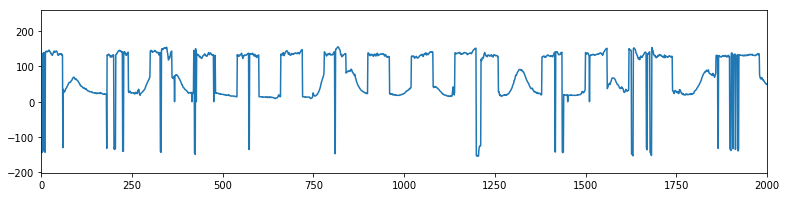

In [ ]:
plt.figure(figsize=[13.0,3.0])
plt.plot(t)
plt.xlim(0,2000)

## Setting up the model 

In [22]:
def get_batches_i(arr, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    # iterate through the array, one sequence at a time
    ECG_wave_range = 61
    num_wave = arr.shape[1]//ECG_wave_range  # It should be an integer
    #print('num_wave:',num_wave)
    for i in range(num_wave): 
        for n in range(0, ECG_wave_range-1, seq_length):
            # x, y: [batch, seq, num_features]
            x = np.zeros((arr.shape[0],seq_length, 2))
            y = np.zeros((arr.shape[0],seq_length, 2))
            x[:, :, 0] = arr[:, i * ECG_wave_range + 1 + n: i * ECG_wave_range + 1+ n + seq_length]
            x[:, :, 1] = np.array([arr[:,0]]*seq_length).T            
            if(((i == (num_wave - 1)) or (num_wave == 1)) and (n == (ECG_wave_range-1 - seq_length))):
                y[:, :-1, 0] = arr[:, i * ECG_wave_range + 1 + n + 1: i * ECG_wave_range + 1+ n + seq_length]
                y[:, :-1, 1] = np.array([arr[:,0]]*(seq_length - 1)).T  
                # repeat the last point in the last batch 
                y[:, -1, 0] = np.concatenate((arr[1:,1],np.array([arr[-1,-1]])))
                y[:, -1, 1] = np.concatenate((arr[1:,0],np.array([arr[-1,0]])))
            else:
                y[:, :, 0] = arr[:, i * ECG_wave_range + 1 + n + 1: i * ECG_wave_range + 1+ n + 1 + seq_length]
                y[:, :, 1] = np.array([arr[:,0]]*seq_length).T            
            
            yield x.astype('float32'), y.astype('float32')         

In [77]:
def get_batches(arr, seq_length, step):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       step: number of time steps to make prediction
       seq_length: Number of encoded chars in a sequence
    '''
    # iterate through the array, one sequence at a time
    ECG_wave_range = 61
    num_wave = arr.shape[1]//ECG_wave_range  # It should be an integer
    #print('num_wave:',num_wave)
    for i in range(num_wave): 
        for n in range(0, ECG_wave_range-1, seq_length):
            # x, y: [batch, seq, num_features]
            x = np.zeros((arr.shape[0],seq_length, 2))
            y = np.zeros((arr.shape[0],seq_length, 2))
            x[:, :, 0] = arr[:, i * ECG_wave_range + 1 + n: i * ECG_wave_range + 1+ n + seq_length]
            x[:, :, 1] = np.array([arr[:,0]]*seq_length).T            
            if(((i == (num_wave - 1)) or (num_wave == 1)) and (n == (ECG_wave_range-1 - seq_length))):
                y[:, :-1*step, 0] = arr[:, i * ECG_wave_range + 1 + n + step: ]
                y[:, :-1*step, 1] = np.array([arr[:,0]]*(seq_length - step)).T  
                # repeat the last point in the last batch 
                #print(arr[1:,1:1+step].shape,np.array([arr[-1,-1]]*step).reshape(1,-1).shape)
                if (step == 1):
                  y[:, -1*step:, 0] = np.concatenate((np.squeeze(arr[1:,1:1+step]),np.array([arr[-1,-1]]*step).T)).reshape(-1,1)
                else:
                  y[:, -1*step:, 0] = np.concatenate((arr[1:,1:1+step],np.array([arr[-1,-1]]*step).reshape(1,-1)))
                y_t = []
                for j in range(arr.shape[0]-1):
                  y_t.append([arr[j+1,0]]*step)
                y_t = np.array(y_t)
                #print(y_t.shape,np.array([arr[-1,0]]*step).T.shape)
                if (step == 1):
                  y[:, -1*step:, 1] = np.concatenate((np.squeeze(y_t),np.array([arr[-1,0]]*step).T)).reshape(-1,1)
                else:
                  y[:, -1*step:, 1] = np.concatenate((y_t,np.array([arr[-1,0]]*step).reshape(1,-1)))
            else:
                y[:, :, 0] = arr[:, i * ECG_wave_range + 1 + n + step: i * ECG_wave_range + 1+ n + step + seq_length]
                y[:, :, 1] = np.array([arr[:,0]]*seq_length).T            
            
            yield x.astype('float32'), y.astype('float32')  

In [21]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [154]:
class CharRNN(nn.Module):
    
    def __init__(self, input_size, n_hidden=256, n_layers=2,
                               drop_prob=0.6, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        # creating character dictionaries
        self.input_size = input_size
        #self.int2char = dict(enumerate(self.chars))
        #self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, input_size)
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        #print('weight data type:',weight.dtype)
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        

## Training the model 

In [121]:
def train(net, data, val_data, step=1, epochs=10, batch_size = 267, seq_length=10, lr=0.001, clip=5, val_frac=0.1, print_every=10,save_file_name = 'model.pt'):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    val_loss_min = np.inf
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # create training and validation data
    #val_idx = int(len(data)*(1-val_frac))
    #data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    #n_chars = len(net.chars)
    val_losses_mean = []
    
    train_losses_mean = []
    for e in range(epochs):
        counter += 1
        # initialize hidden state
        h = net.init_hidden(batch_size)
        #print('initialize h...')
        train_losses = []
        for x, y in get_batches(data, seq_length, step):
            
            
            # One-hot encode our data and make them Torch tensors
            #x = one_hot_encode(x, n_chars)
            #print('x data type:',x.dtype)
            x = x.astype('float32')
            y = y.astype('float32')
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            #print('data type:',inputs.dtype)
            output, h = net(inputs, h)
            
            # calculate the loss and perform backprop

            loss = criterion(output, targets.view(batch_size*seq_length,-1))
            train_losses.append(loss.item())
            loss.backward()
                        
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
          # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
                
            net.eval()
            val_losses = []
            val_data_plot_input_0 = []
            val_data_plot_output_0 = []
            val_data_plot_target_0 = []
            val_data_plot_input_1 = []
            val_data_plot_output_1 = [] 
            val_data_plot_target_1 = []
                
            val_data_plot_input_0_2 = []
            val_data_plot_output_0_2 = []
            val_data_plot_target_0_2 = []
            val_data_plot_input_1_2 = []
            val_data_plot_output_1_2 = [] 
            val_data_plot_target_1_2 = []     
                
            val_data_plot_input_0_3 = []
            val_data_plot_output_0_3 = []
            val_data_plot_target_0_3 = []
            val_data_plot_input_1_3 = []
            val_data_plot_output_1_3 = [] 
            val_data_plot_target_1_3 = []                 
            for x, y in get_batches(val_data, seq_length, step):
                # One-hot encode our data and make them Torch tensors
                #x = one_hot_encode(x, n_chars)
                x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])
                    
                inputs, targets = x, y
                if(train_on_gpu):
                    inputs, targets = inputs.cuda(), targets.cuda()

                output, val_h = net(inputs, val_h)

                if(train_on_gpu):
                    output = output.cpu()               
                    
                val_data_plot_input_0.append(list(inputs[0,:,0]))
                val_data_plot_target_0.append(list(targets[0,:,0]))
                val_data_plot_output_0.append(list(output.detach().numpy().reshape(batch_size,seq_length,-1)[0,:,0]))   
                    
                val_data_plot_input_1.append(list(inputs[0,:,1]))
                val_data_plot_target_1.append(list(targets[0,:,1]))
                val_data_plot_output_1.append(list(output.detach().numpy().reshape(batch_size,seq_length,-1)[0,:,1]))                 

                val_data_plot_input_0_2.append(list(inputs[1,:,0]))
                val_data_plot_target_0_2.append(list(targets[1,:,0]))
                val_data_plot_output_0_2.append(list(output.detach().numpy().reshape(batch_size,seq_length,-1)[1,:,0]))   
                    
                val_data_plot_input_1_2.append(list(inputs[1,:,1]))
                val_data_plot_target_1_2.append(list(targets[1,:,1]))
                val_data_plot_output_1_2.append(list(output.detach().numpy().reshape(batch_size,seq_length,-1)[1,:,1]))                 

                val_data_plot_input_0_3.append(list(inputs[2,:,0]))
                val_data_plot_target_0_3.append(list(targets[2,:,0]))
                val_data_plot_output_0_3.append(list(output.detach().numpy().reshape(batch_size,seq_length,-1)[2,:,0]))   
                    
                val_data_plot_input_1_3.append(list(inputs[2,:,1]))
                val_data_plot_target_1_3.append(list(targets[2,:,1]))
                val_data_plot_output_1_3.append(list(output.detach().numpy().reshape(batch_size,seq_length,-1)[2,:,1]))                                     
                    
                if(train_on_gpu):
                    output = output.cuda()                      
                    
                val_loss = criterion(output.view(output.shape[0]*output.shape[1]), targets.view(batch_size*seq_length*2))
                
                val_losses.append(val_loss.item())
                
            net.train() # reset to train mode after iterationg through validation data
                
            #print(np.array(val_data_plot_input_0).shape,np.array(val_data_plot_output_0).shape,np.array(val_data_plot_target_0).shape)
            val_data_plot_input_0 = np.array(val_data_plot_input_0).flatten()
            val_data_plot_output_0 = np.array(val_data_plot_output_0).flatten()
            val_data_plot_target_0 = np.array(val_data_plot_target_0).flatten()
            val_data_plot_input_1 = np.array(val_data_plot_input_1).flatten()
            val_data_plot_output_1 = np.array(val_data_plot_output_1).flatten()   
            val_data_plot_target_1 = np.array(val_data_plot_target_1).flatten()
                
            val_data_plot_input_0_2 = np.array(val_data_plot_input_0_2).flatten()
            val_data_plot_output_0_2 = np.array(val_data_plot_output_0_2).flatten()
            val_data_plot_target_0_2 = np.array(val_data_plot_target_0_2).flatten()
            val_data_plot_input_1_2 = np.array(val_data_plot_input_1_2).flatten()
            val_data_plot_output_1_2 = np.array(val_data_plot_output_1_2).flatten()   
            val_data_plot_target_1_2 = np.array(val_data_plot_target_1_2).flatten()  
                
            val_data_plot_input_0_3 = np.array(val_data_plot_input_0_3).flatten()
            val_data_plot_output_0_3 = np.array(val_data_plot_output_0_3).flatten()
            val_data_plot_target_0_3 = np.array(val_data_plot_target_0_3).flatten()
            val_data_plot_input_1_3 = np.array(val_data_plot_input_1_3).flatten()
            val_data_plot_output_1_3 = np.array(val_data_plot_output_1_3).flatten()   
            val_data_plot_target_1_3 = np.array(val_data_plot_target_1_3).flatten()                  
                
            val_data_plot_input_0 = np.concatenate((val_data_plot_input_0,val_data_plot_input_0_2))
            val_data_plot_output_0 = np.concatenate((val_data_plot_output_0,val_data_plot_output_0_2))
            val_data_plot_target_0 = np.concatenate((val_data_plot_target_0,val_data_plot_target_0_2))
            val_data_plot_input_1 = np.concatenate((val_data_plot_input_1,val_data_plot_input_1_2))
            val_data_plot_output_1 = np.concatenate((val_data_plot_output_1,val_data_plot_output_1_2))
            val_data_plot_target_1 = np.concatenate((val_data_plot_target_1,val_data_plot_target_1_2))
                
            val_data_plot_input_0 = np.concatenate((val_data_plot_input_0,val_data_plot_input_0_3))
            val_data_plot_output_0 = np.concatenate((val_data_plot_output_0,val_data_plot_output_0_3))
            val_data_plot_target_0 = np.concatenate((val_data_plot_target_0,val_data_plot_target_0_3))
            val_data_plot_input_1 = np.concatenate((val_data_plot_input_1,val_data_plot_input_1_3))
            val_data_plot_output_1 = np.concatenate((val_data_plot_output_1,val_data_plot_output_1_3))
            val_data_plot_target_1 = np.concatenate((val_data_plot_target_1,val_data_plot_target_1_3))                
            #    

            print("Epoch: {}/{}...".format(e+1, epochs),
                "Step: {}...".format(counter),
                "Loss: {:.4f}...".format(np.mean(train_losses)),
                "Val Loss: {:.4f}".format(np.mean(val_losses)))
            val_losses_mean.append(np.mean(val_losses))
            train_losses_mean.append(np.mean(train_losses))

            if np.mean(val_losses) <= val_loss_min:
                torch.save(net.state_dict(), save_file_name)
                val_loss_min = np.mean(val_losses)
            #train_losses.append(loss.item())            
            #=== generate plots ===

            plt.figure(figsize=[20.0,6.0])
            plt.subplot(221)
            plt.plot(np.arange(len(val_data_plot_input_0)),val_data_plot_input_0.flatten(),color='skyblue')
            plt.scatter(np.arange(len(val_data_plot_input_0)),val_data_plot_input_0,color='skyblue')
            plt.plot(np.arange(len(val_data_plot_output_0)),val_data_plot_output_0,color='orange')
            plt.plot(np.arange(len(val_data_plot_output_0)),val_data_plot_output_0,color='orange')
            plt.plot(np.arange(len(val_data_plot_target_0)),val_data_plot_target_0,color='red')
            plt.plot(np.arange(len(val_data_plot_target_0)),val_data_plot_target_0,color='red')                
            #plt.xlim(0,50)
            plt.subplot(222)
            plt.plot(np.arange(len(val_data_plot_input_1)),val_data_plot_input_1.flatten(),color='blue')
            plt.scatter(np.arange(len(val_data_plot_input_1)),val_data_plot_input_1,color='blue')
            plt.plot(np.arange(len(val_data_plot_output_1)),val_data_plot_output_1,color='darkorange')
            plt.plot(np.arange(len(val_data_plot_output_1)),val_data_plot_output_1,color='darkorange')
            plt.plot(np.arange(len(val_data_plot_target_1)),val_data_plot_target_1,color='darkred')
            plt.plot(np.arange(len(val_data_plot_target_1)),val_data_plot_target_1,color='darkred')                 
            #plt.xlim(0,50)
            plt.subplot(223)
            plt.plot(train_losses_mean,color='royalblue')
            plt.plot(val_losses_mean,color='orange')
            plt.show()                
                


    return  net, train_losses_mean, val_losses_mean

In [323]:
# define and print the net
n_hidden=700
n_layers=2
input_size = 2

net = CharRNN(input_size, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(2, 700, num_layers=2, batch_first=True, dropout=0.6)
  (dropout): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=700, out_features=2, bias=True)
)


In [111]:
print(train_data.shape)
print(test_data.shape)

(267, 427)
(267, 61)


(267, 427) (267, 61)
Epoch: 5/150... Step: 5... Loss: 0.3981... Val Loss: 0.4422


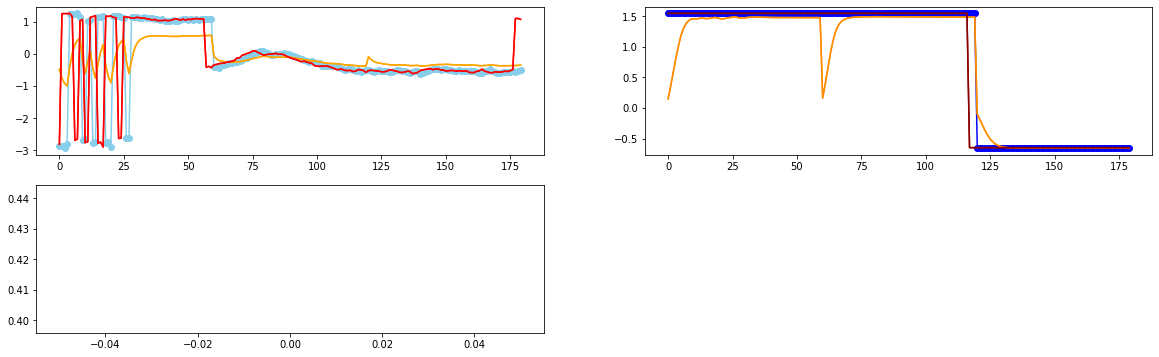

Epoch: 10/150... Step: 10... Loss: 0.3851... Val Loss: 0.4351


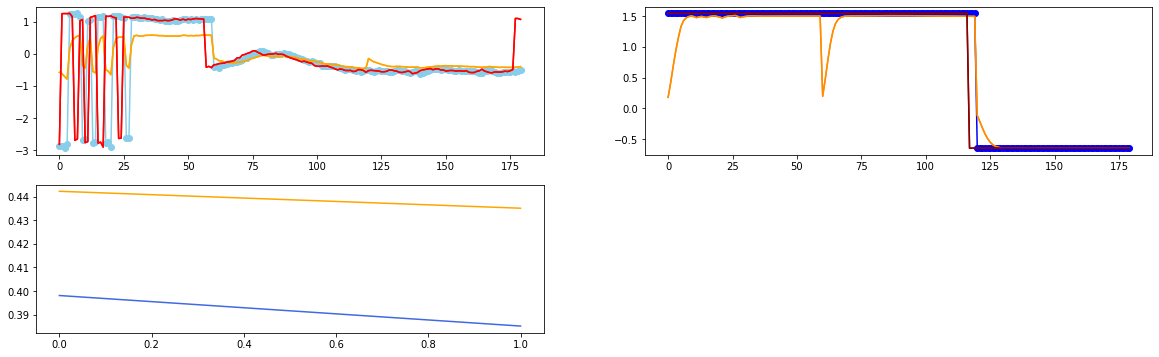

Epoch: 15/150... Step: 15... Loss: 0.3812... Val Loss: 0.4272


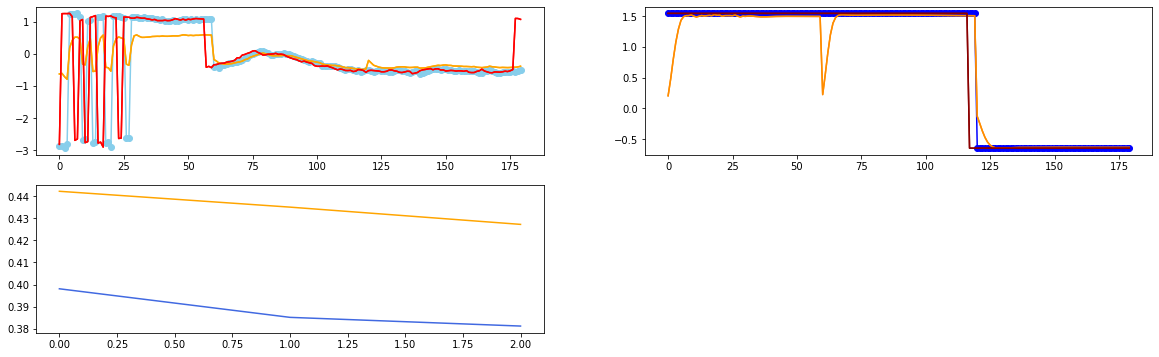

Epoch: 20/150... Step: 20... Loss: 0.3787... Val Loss: 0.4244


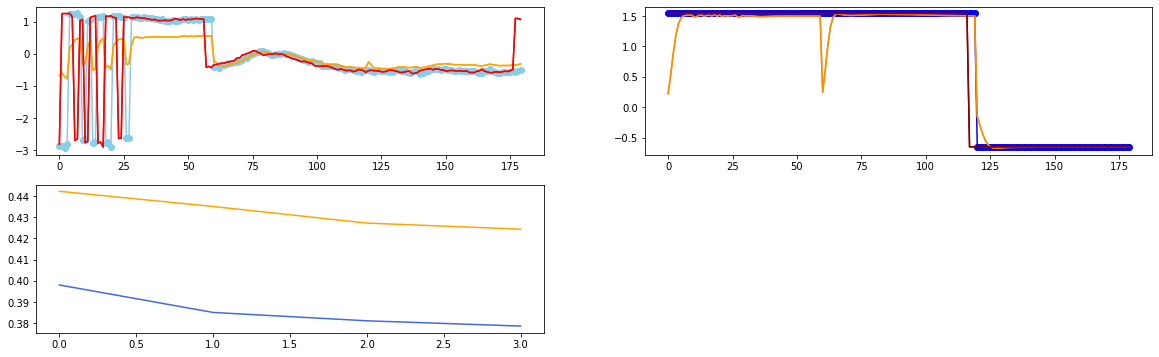

Epoch: 25/150... Step: 25... Loss: 0.3773... Val Loss: 0.4236


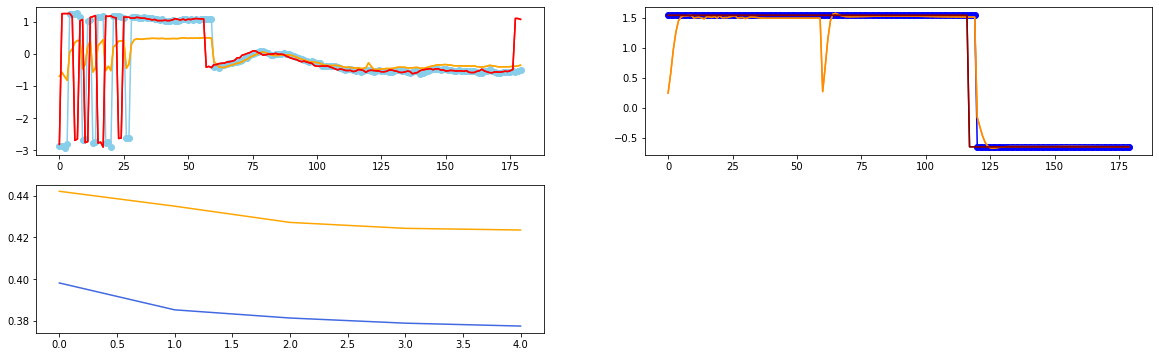

Epoch: 30/150... Step: 30... Loss: 0.3761... Val Loss: 0.4215


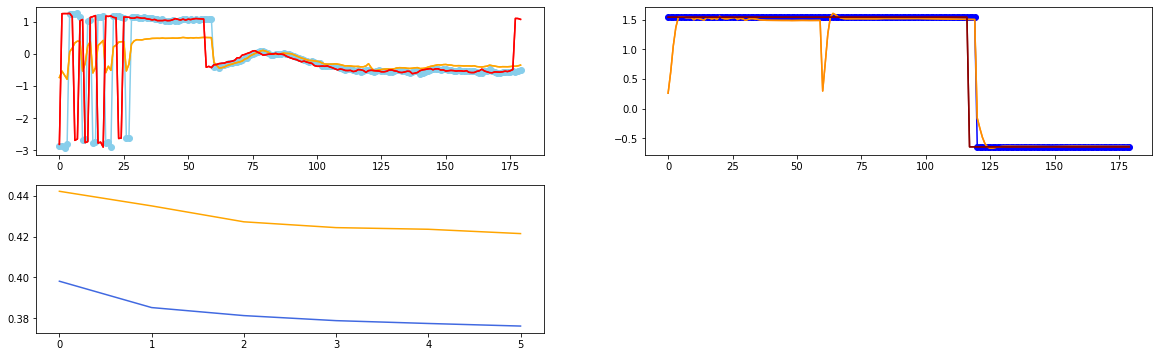

Epoch: 35/150... Step: 35... Loss: 0.3748... Val Loss: 0.4210


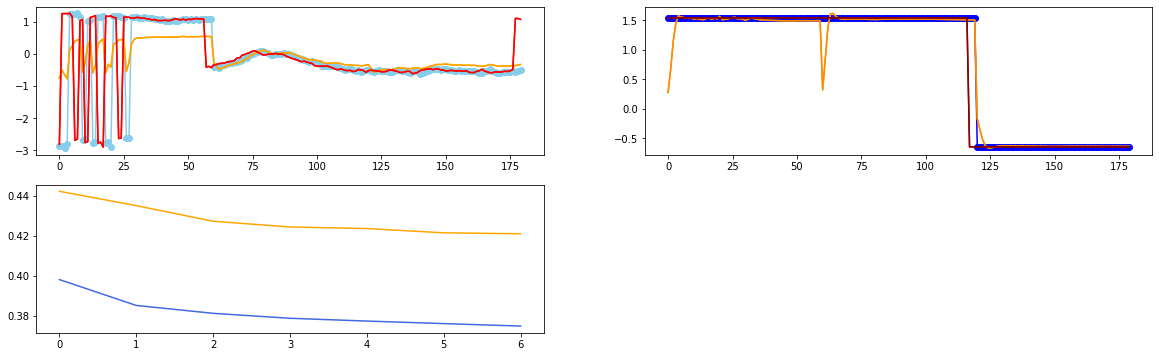

Epoch: 40/150... Step: 40... Loss: 0.3749... Val Loss: 0.4194


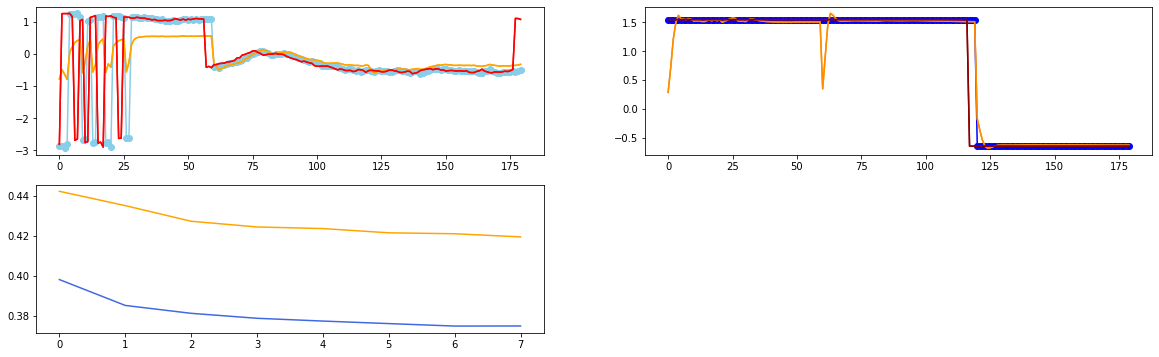

Epoch: 45/150... Step: 45... Loss: 0.3741... Val Loss: 0.4181


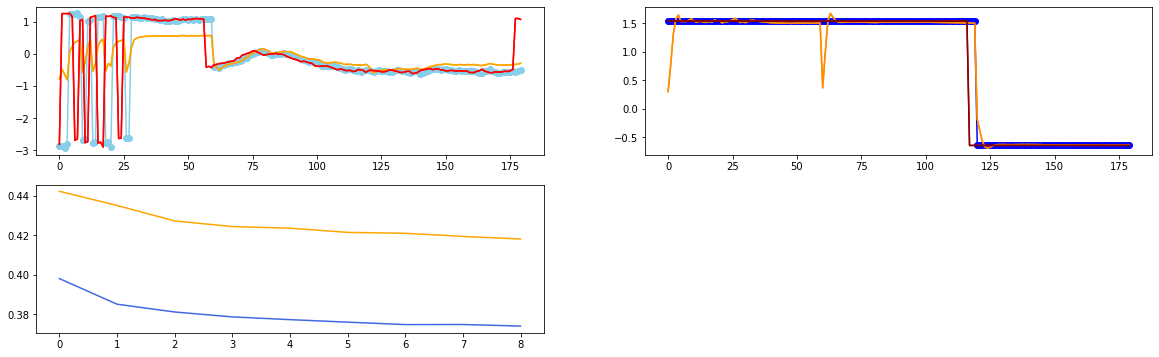

Epoch: 50/150... Step: 50... Loss: 0.3733... Val Loss: 0.4199


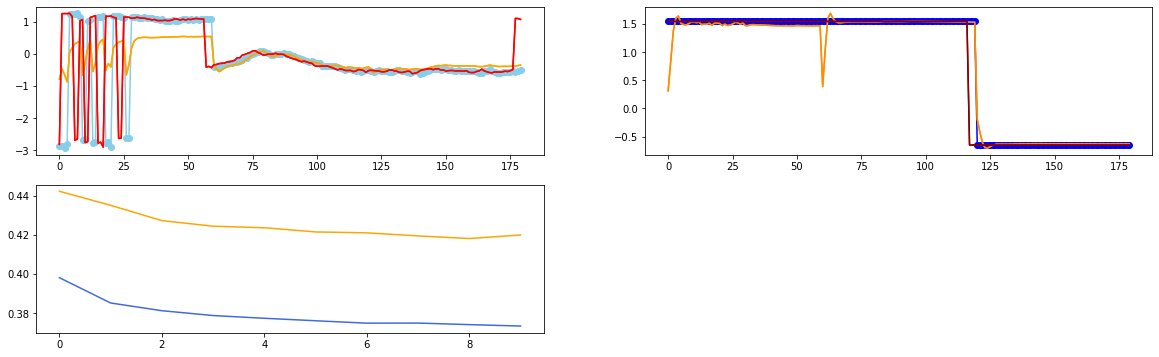

Epoch: 55/150... Step: 55... Loss: 0.3729... Val Loss: 0.4188


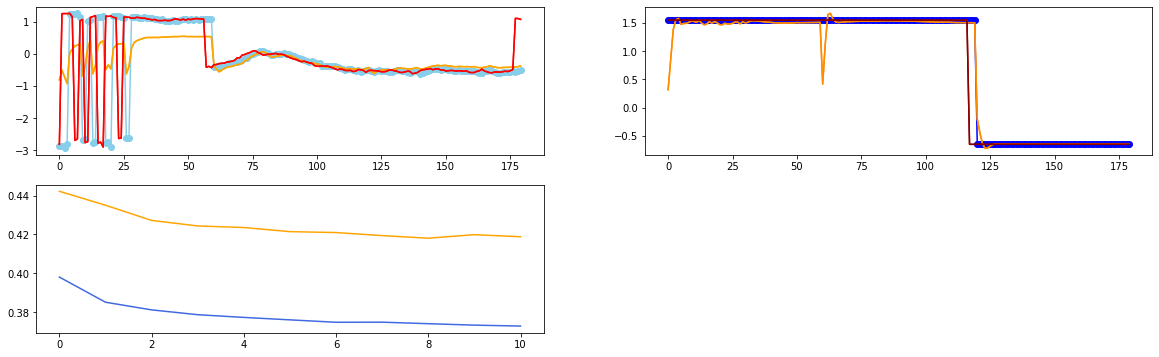

Epoch: 60/150... Step: 60... Loss: 0.3710... Val Loss: 0.4178


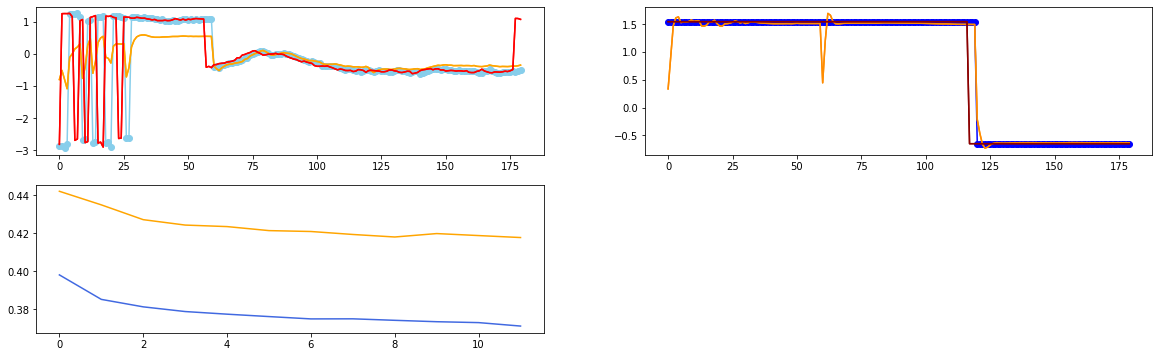

Epoch: 65/150... Step: 65... Loss: 0.3701... Val Loss: 0.4186


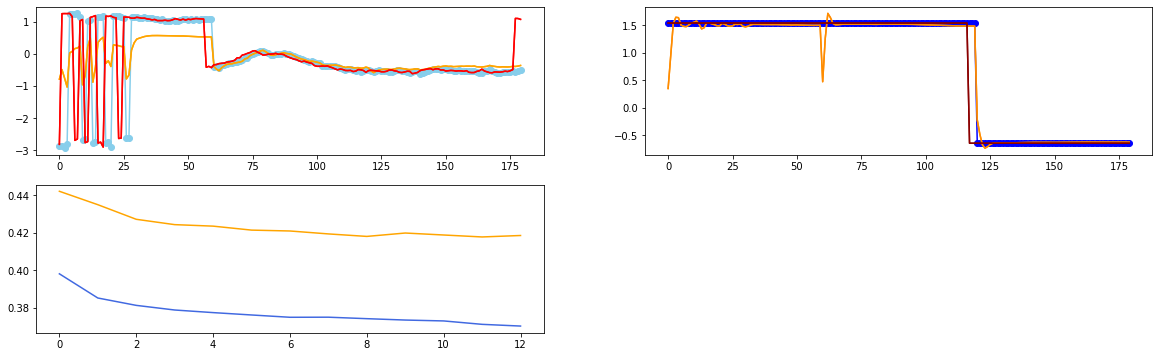

Epoch: 70/150... Step: 70... Loss: 0.3706... Val Loss: 0.4161


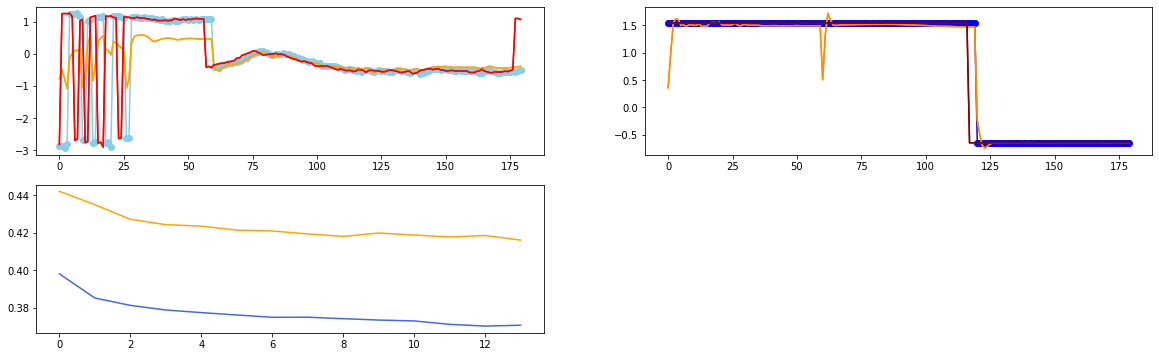

Epoch: 75/150... Step: 75... Loss: 0.3687... Val Loss: 0.4167


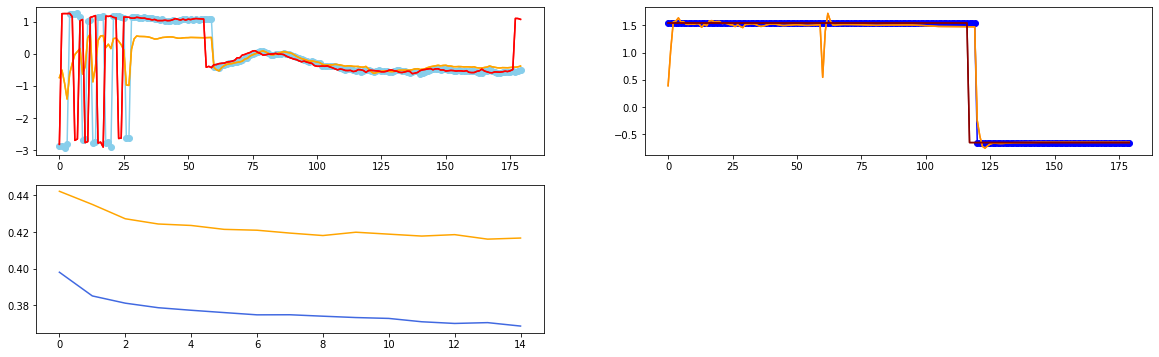

Epoch: 80/150... Step: 80... Loss: 0.3668... Val Loss: 0.4192


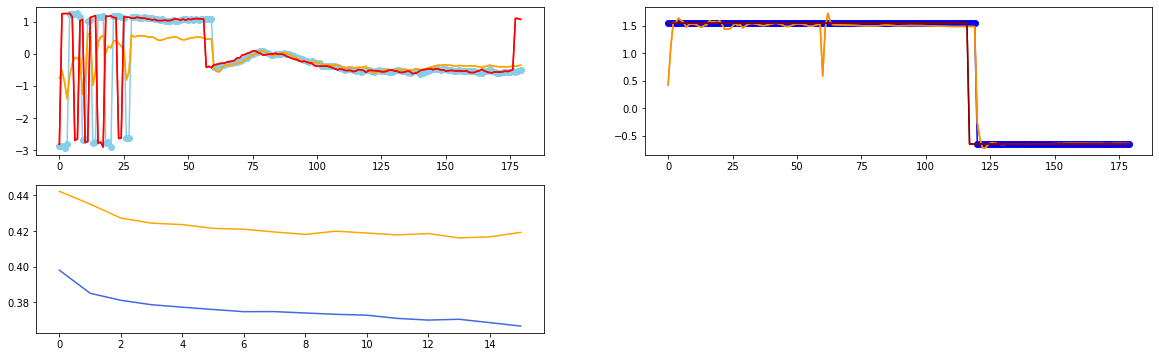

Epoch: 85/150... Step: 85... Loss: 0.3639... Val Loss: 0.4157


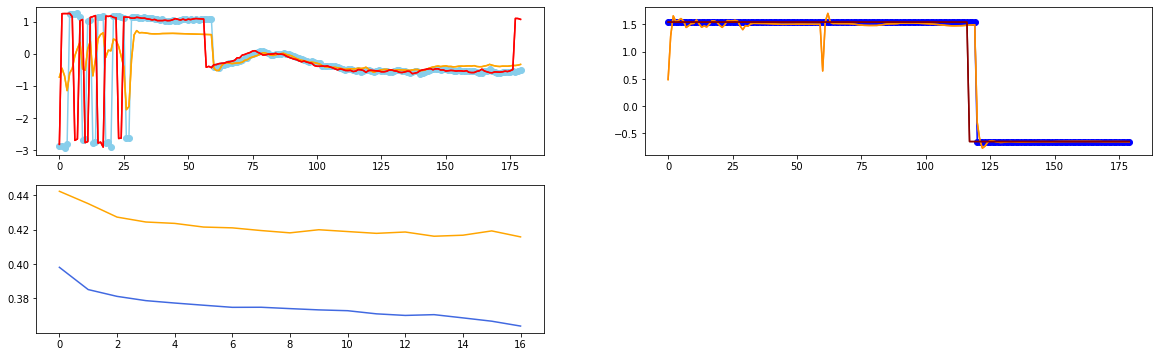

Epoch: 90/150... Step: 90... Loss: 0.3620... Val Loss: 0.4186


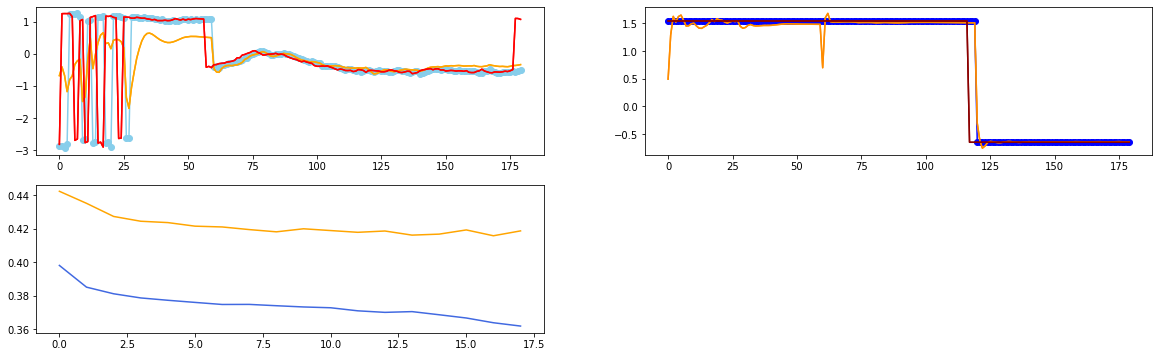

Epoch: 95/150... Step: 95... Loss: 0.3586... Val Loss: 0.4231


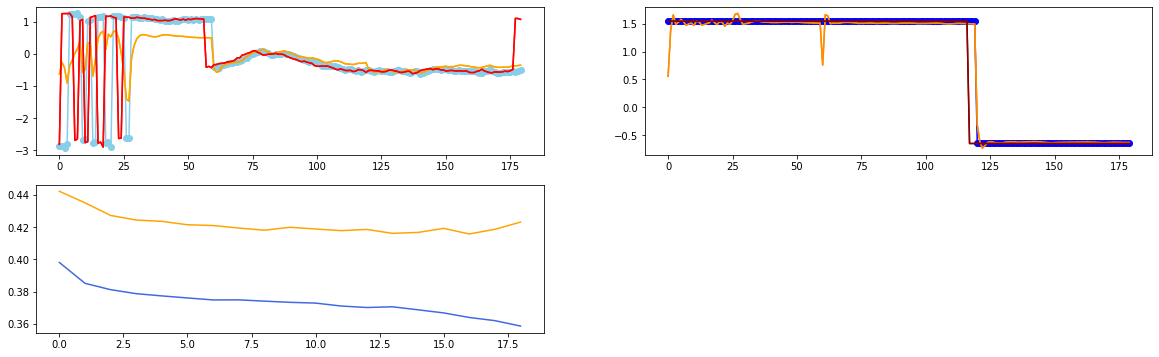

Epoch: 100/150... Step: 100... Loss: 0.3536... Val Loss: 0.4304


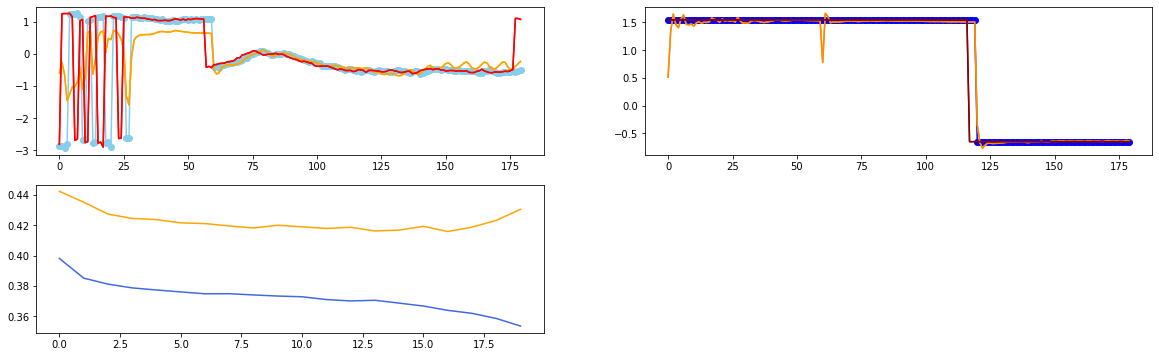

Epoch: 105/150... Step: 105... Loss: 0.3463... Val Loss: 0.4368


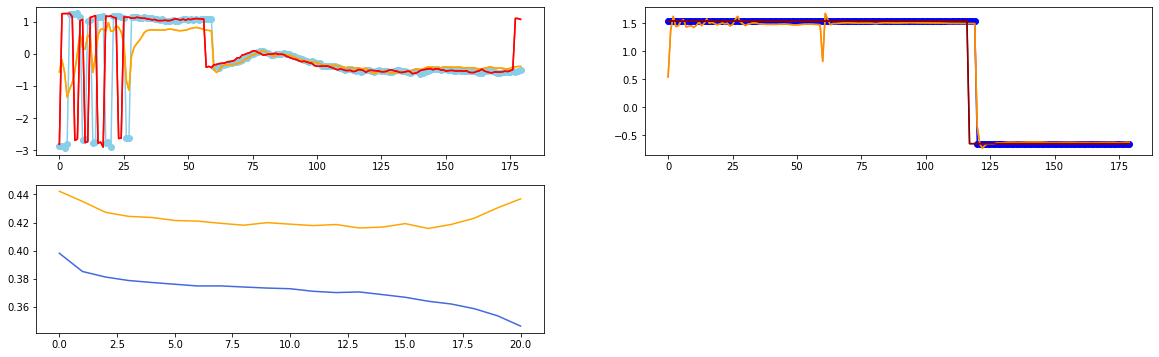

Epoch: 110/150... Step: 110... Loss: 0.3408... Val Loss: 0.4342


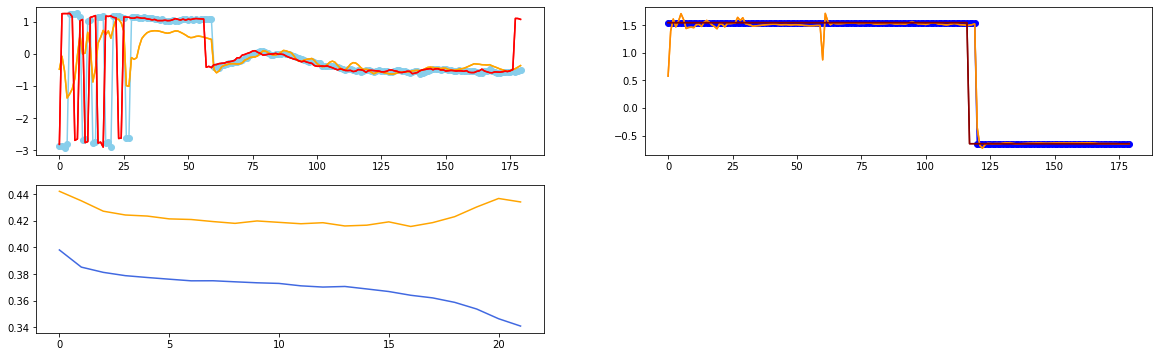

Epoch: 115/150... Step: 115... Loss: 0.3327... Val Loss: 0.4411


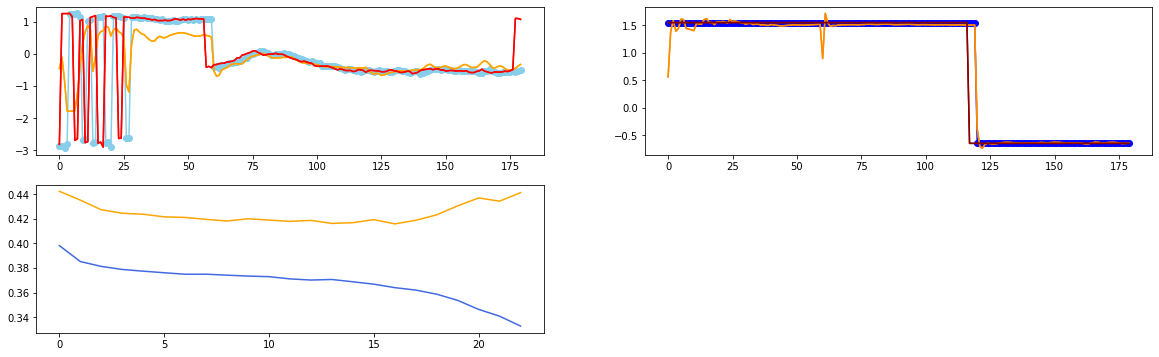

Epoch: 120/150... Step: 120... Loss: 0.3272... Val Loss: 0.4402


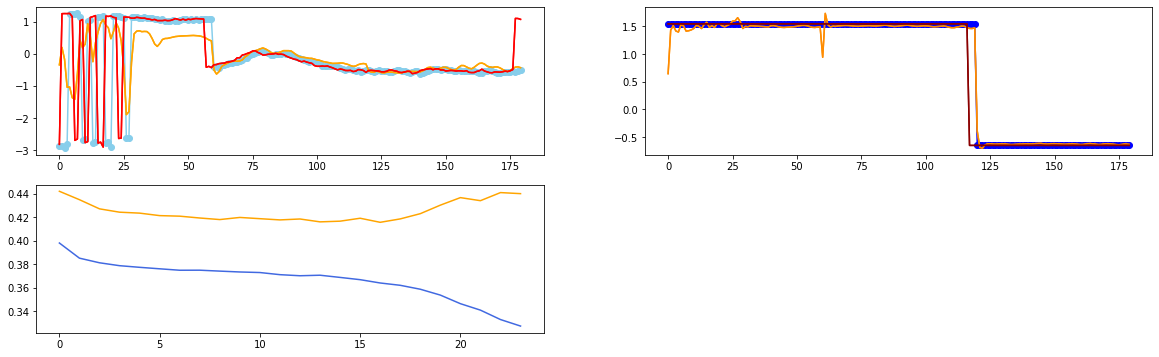

Epoch: 125/150... Step: 125... Loss: 0.3205... Val Loss: 0.4581


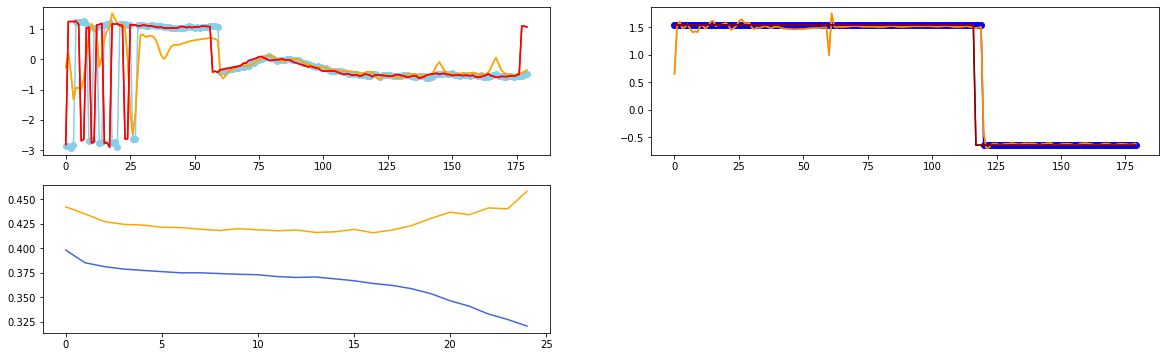

Epoch: 130/150... Step: 130... Loss: 0.3090... Val Loss: 0.4583


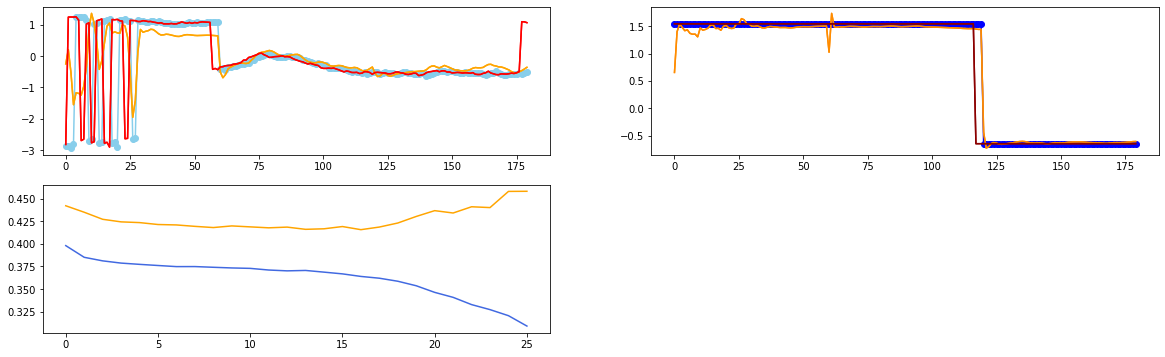

Epoch: 135/150... Step: 135... Loss: 0.3011... Val Loss: 0.4753


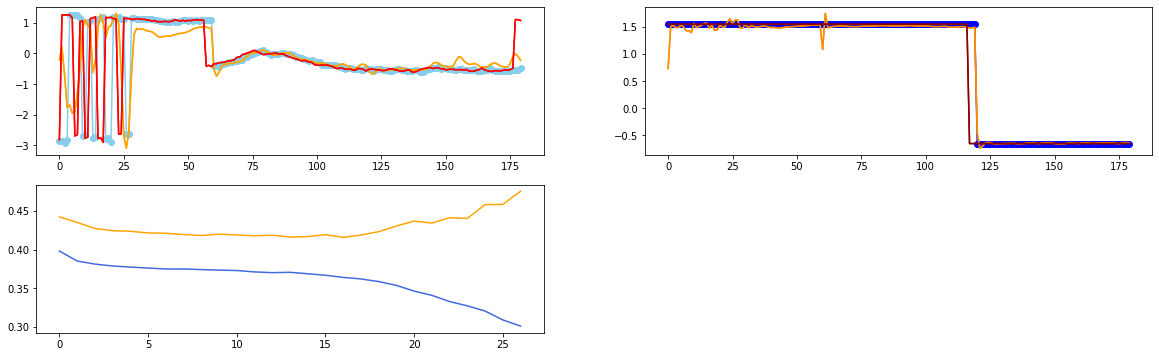

Epoch: 140/150... Step: 140... Loss: 0.2973... Val Loss: 0.4648


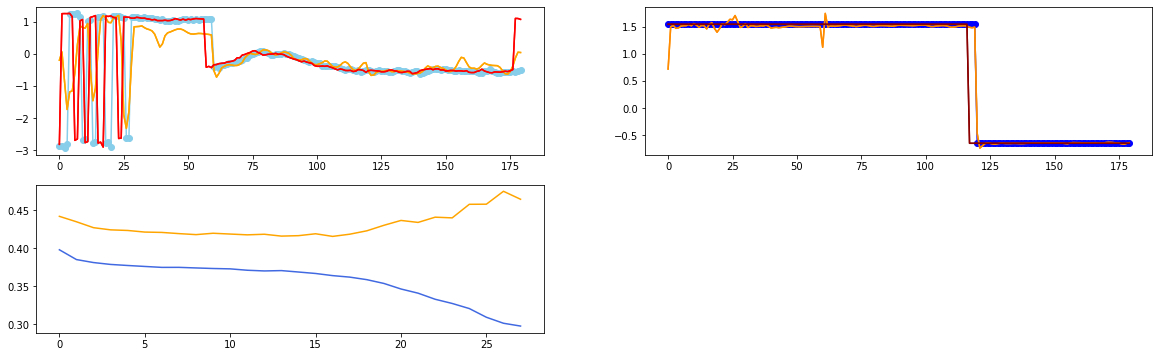

Epoch: 145/150... Step: 145... Loss: 0.2896... Val Loss: 0.4773


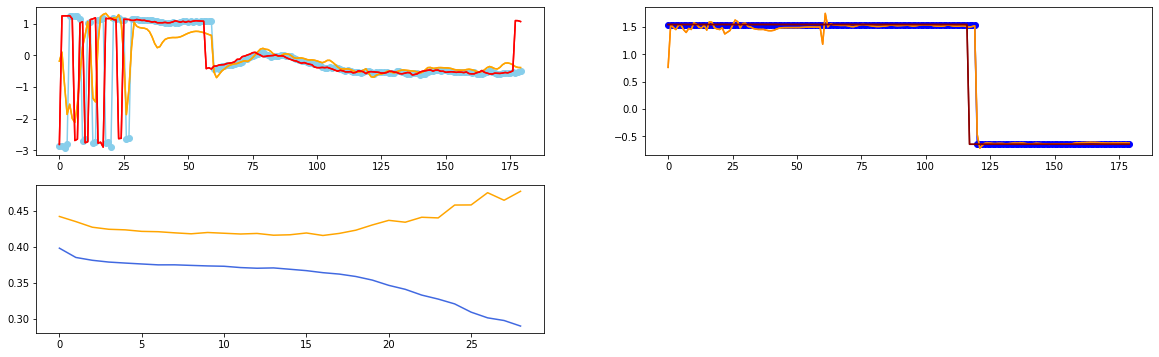

Epoch: 150/150... Step: 150... Loss: 0.2808... Val Loss: 0.4665


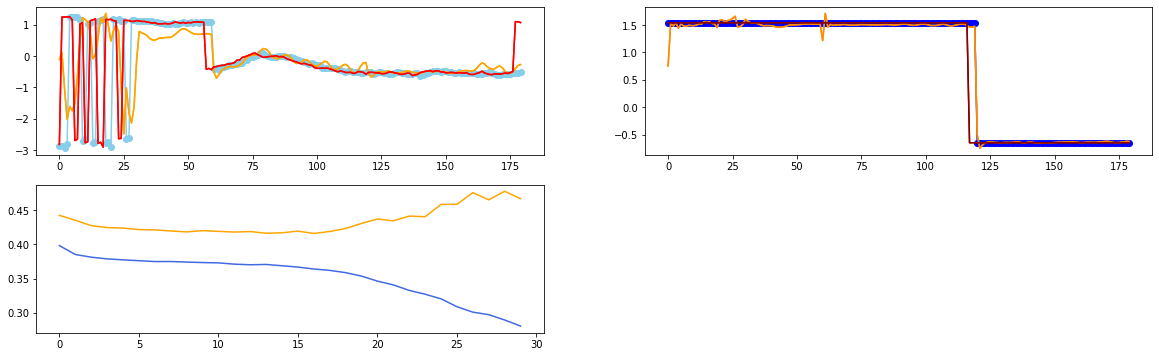

In [324]:
batch_size = train_data.shape[0]
seq_length = 20
step = 3 # prediction steps
n_epochs = 150 # start smaller if you are just testing initial behavior

# train the model
train_data= train_data.astype('float32')
test_data= test_data.astype('float32')
print(train_data.shape,test_data.shape)

#net, data, val_data, epochs=10, batch_size = 267, seq_length=10, lr=0.001, clip=5, val_frac=0.1, print_every=10
trained_net, train_losses, val_losses = train(net, train_data, test_data, step = step, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=5, save_file_name = 'model_LSTM_step_3_dep_2_seq_20_nh_700_t2')

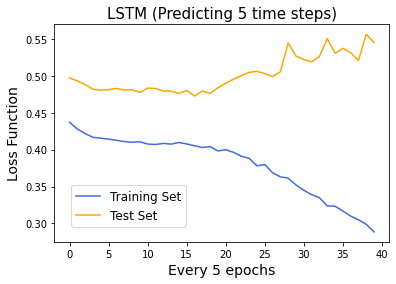

In [157]:
plt.plot(train_losses,color='royalblue',label = 'Training Set')
plt.plot(val_losses,color = 'orange',label = 'Test Set')
plt.xlabel('Every 5 epochs',fontsize = 14) 
plt.ylabel('Loss Function',fontsize = 14) 
plt.title('LSTM (Predicting 5 time steps)',fontsize = 15)
plt.legend(bbox_to_anchor=(0.05, 0.07),loc=3, borderaxespad=0.,prop={'size':12})


plt.savefig('/content/drive/My Drive/Colab Notebooks/ECG_data/loss_fn_step_5_dep_2_seq_20_nh_700.png')

## Plotting the prediction

In [320]:
net.load_state_dict(torch.load('model_LSTM_step_5_dep_2_seq_20_nh_700_t'))

<All keys matched successfully>

0 [1, 2, 3]
x,y
ct= 1
case 1: 1 0 5
case 2: 1 0 5
1 [1, 2, 3]
x,y
ct= 2
case 1: 2 1 5
case 2: 2 1 5
2 [1, 2, 3]
x,y
ct= 3
case 1: 3 2 5
case 2: 3 2 5


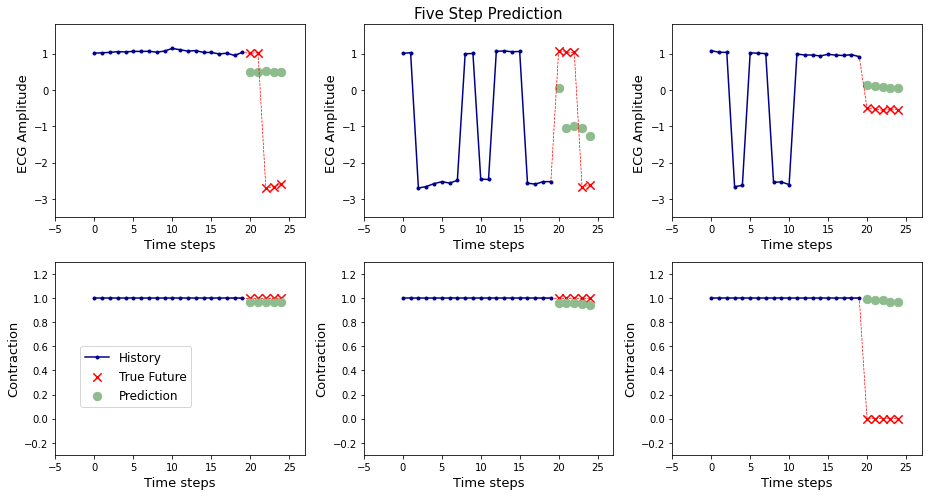

In [322]:
net.eval()
val_h = net.init_hidden(batch_size)

ct = 0
sec_num = [1,2,3]
step = 5
ct_t_2 = 0
ct_t = 0
plt.figure(figsize=[13.0,7.0])
for x, y in get_batches(test_data, seq_length, step):
    print(ct,sec_num)
    x, y = torch.from_numpy(x), torch.from_numpy(y)
    print('x,y')

    val_h = tuple([each.data for each in val_h])
                    
    inputs, targets = x, y
    if(train_on_gpu):
        inputs, targets = inputs.cuda(), targets.cuda()

    output, val_h = net(inputs, val_h)

    if(train_on_gpu):
        output = output.cpu() 
        inputs = inputs.cpu() 
        targets = targets.cpu()               
    ct += 1
    ind = 5
    if (ct in sec_num):  
        for ind in [5]:
            plt.subplot(2,3,int(ct_t+1))
            print('case 1:',ct,ct_t,ind)
            ct_t+=1
            plt.scatter(np.arange(step,step+len(inputs[ind,:,0]))[-1*step:],targets[ind,:,0][-1*step:],color='red',marker='x',s=70,label='True Future') 
            plt.plot(np.arange(step,step+len(inputs[ind,:,0]))[-8:],targets[ind,:,0][-8:],'--',color='red',lw=0.7,) 
         
            plt.plot(np.arange(len(inputs[ind,:,0])),inputs[ind,:,0],marker='o',ms=3.0,color='darkblue',label='History')    

            plt.scatter(np.arange(step,step+len(inputs[ind,:,0]))[-1*step:],output.detach().numpy().reshape(batch_size,seq_length,-1)[ind,:,0][-1*step:],color='darkseagreen',s=70,label='Prediction')   
            plt.ylim(-3.5,1.8)
            plt.xlim(-5.0,27.0)
            plt.xlabel('Time steps',fontsize=13)
            plt.ylabel('ECG Amplitude ',fontsize=13)
            if (ct_t == 2):
                plt.title('Five Step Prediction',fontsize=15)


        
        for ind in [5]:
            plt.subplot(2,3,int(3+ct_t_2+1))
            ct_t_2+=1
            plt.scatter(np.arange(step,step+len(inputs[ind,:,0]))[-1*step:],(targets[ind,:,1][-1*step:]-(-0.6481))/(1.5430-(-0.6481)),color='red',marker='x',s=70,label='True Future') 
            plt.plot(np.arange(step,step+len(inputs[ind,:,0]))[-8:],(targets[ind,:,1][-8:]-(-0.6481))/(1.5430-(-0.6481)),'--',color='red',lw=0.7,) 
         
            plt.plot(np.arange(len(inputs[ind,:,0])),(inputs[ind,:,1]-(-0.6481))/(1.5430-(-0.6481)),marker='o',ms=3.0,color='darkblue',label='History')    

            plt.scatter(np.arange(step,step+len(inputs[ind,:,0]))[-1*step:],(output.detach().numpy().reshape(batch_size,seq_length,-1)[ind,:,1][-1*step:]-(-0.6481))/(1.5430-(-0.6481)),color='darkseagreen',s=70,label='Prediction')   
            plt.ylim(-0.3,1.3)
            plt.xlim(-5.0,27.0)
            plt.xlabel('Time steps',fontsize=13)
            plt.ylabel('Contraction',fontsize=13)   
            if (ct_t_2 == 1):
                plt.legend(bbox_to_anchor=(0.1, 0.25),loc=3, borderaxespad=0.,prop={'size':12})                         
        if (ct_t_2 == 3):
            plt.tight_layout()
            plt.savefig('/content/drive/My Drive/Colab Notebooks/ECG_data/LSTM_prediction_step_5_dep_2_seq_20_nh_700.png')
            plt.show()
            break   

    
    